<a href="https://colab.research.google.com/github/dmar10862/uoc_tipologia_y_ciclo_de_vida_de_los_datos_practica_2/blob/master/src/UOC_M2851_DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tipología y ciclo de vida de los datos  - PRAC2**

Limpieza y análisis de datos

**David Marín Sánchez**

Junio 2020

**Descripción y referencias**

En esta práctica se ha tratado de resolver el problema planeado en la competición de Kaggle [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/overview).

Para resolverlo se han utilizado ideas y métodos planteadas en las siguientes enlaces:

https://www.kaggle.com/ouyangg/titanic

https://www.kaggle.com/parthsuresh/binary-classifier-using-keras-97-98-accuracy

https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/

https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

https://github.com/Kaggle/kaggle-api

https://scikit-learn.org/stable/modules/impute.html

https://scikit-learn.org/dev/modules/generated/sklearn.impute.KNNImputer.html

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

https://scikit-learn.org/stable/modules/neural_networks_supervised.html#mlp-tips

https://nextjournal.com/schmudde/how-to-remove-outliers-in-data

https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.bar.html

https://seaborn.pydata.org/examples/many_pairwise_correlations.html


# 0 - Preparación del entorno

## Definición de parámetros

In [0]:
# Limpieza de datos
# Proporción de outliers a eliminar (a partir de los cuantiles)
remove_outilers_quantile = 0.15
# Número de categorias en las que agrupar la variable 'age'
age_categories = 10
# Número de categorias en las que agrupar la variable 'fare'
fare_categories = 10
# Dimensiones a eliminar después del análisis PCA
dimensions_to_remove = 0


# Modelos predictivos
# Proporción de muestras de validación
val_size = 0.1

# Modelado de red neuronal
# Número de neuronas de la capa oculta
neurons = 32
# Ratio de aprendizaje
lr = 0.0002
# Épocas o repeticiones del proceso de entrenamiento de la red neuronal
epochs = 200
# Muestras a procesar en cada paso de entrenamiento
batch_size = 1
# Pacieiencia o número de épocas en las que se permite que el que el error obtenido 
# supere al anterior error antes de parar el proceso de entrenamiento
patience = 10


# Subir predicciones a Kaggle
# Subir predicciones del modelo de regresión
lr_pred_to_kaggle = True
# Subir predicciones del modelo de red neuronal
ann_pred_to_kaggle = True

## Carga de librerias

In [2]:
from google.colab import drive
from google.colab import auth
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from scipy import stats
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1 - Adquisición de los datos

## Descargar dataset de Kaggle

In [3]:
# Montar Google Drive para poder recuperar las credenciales de Kaggle
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%%bash
# Instalar kaggle
pip install -q kaggle

# Cargar las credeciales de Kaggle de Google Drive
mkdir -p /root/.kaggle
cp -a "/content/drive/My Drive/Credentials/kaggle.json" /root/.kaggle/kaggle.json
ls -l /root/.kaggle

total 4
-rw------- 1 root root 64 May  9 08:42 kaggle.json


In [5]:
# Descargar dataset de Kaggle
%%bash
mkdir -p datasets
cd datasets
kaggle competitions download -c titanic
ls -la

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
total 100
drwxr-xr-x 2 root root  4096 Jun  1 08:17 .
drwxr-xr-x 1 root root  4096 Jun  1 09:57 ..
-rw-r--r-- 1 root root  3258 Jun  1 08:17 gender_submission.csv
-rw-r--r-- 1 root root 28629 Jun  1 08:17 test.csv
-rw-r--r-- 1 root root 61194 Jun  1 08:17 train.csv


## Cargar los datos en el notebook

In [0]:
# Se carga el dataset de entrenamiento como un DataFrame de Pandas
df_train = pd.read_csv('datasets/train.csv', index_col = 'PassengerId') 

In [0]:
# Se separan las caracteristicas de la variable objetivo ('Survived')
X_train = df_train.copy()
y_train = X_train[['Survived']]
X_train = X_train.drop(columns=['Survived'])

In [8]:
# Se muestran las características del DataFrame de entrenamiento
display(X_train.info())
display(X_train.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 76.6+ KB


None

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
# Se muestra la variable objetivo para el DataFrame de entremanieto
display(y_train.info())
display(y_train.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Survived  891 non-null    int64
dtypes: int64(1)
memory usage: 13.9 KB


None

,Survived
PassengerId,
1,0
2,1
3,1
4,1
5,0


In [0]:
# Se carga el dataset de test en un DataFrame de Pandas
df_test = pd.read_csv('datasets/test.csv', index_col='PassengerId') 
X_test = df_test.copy()

In [11]:
# Se muestran las características del DataFrame de test
display(X_test.info())
display(X_test.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


None

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# 2 - Análisis de datos preliminar

## Análisis estadístico descriptivo

In [12]:
# Estadísticas del DataFrame de entrenamiento
display(X_train.describe())

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


In [13]:
# Estadísticas del DataFrame test
display(X_test.describe())

,Pclass,Age,SibSp,Parch,Fare
count,418.000000,332.000000,418.000000,418.000000,417.000000
mean,2.265550,30.272590,0.447368,0.392344,35.627188
std,0.841838,14.181209,0.896760,0.981429,55.907576
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,1.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,27.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.500000
max,3.000000,76.000000,8.000000,9.000000,512.329200


## Análisis de normalidad y homocedasticidad

In [0]:
# Se define una función para realizar el análisis de normalidad
def normality_test(X, variable):
  # Se aplica el test Shapiro-Wilk para la variable
  statistic, pvalue = stats.shapiro(X[variable])
  print('statistic = '+str(statistic))
  print('pvalue = '+str(pvalue))

  if pvalue < 0.05:
    print("La distribución no se ajusta a una distribución normal")
  if pvalue > 0.05:
    print("La distribución se ajusta a una distribución normal")
    
  # Se muestra el histograma de la variable
  plot = sns.distplot(X[variable]);

In [0]:
# Se define una función para realizar el análisis de homocedasticidad
def homoscedasticity_test(X, variable):
  # Se aplica el test Fligner-Killeen para la variable
  # según si la persona sobrevivió o no
  statistic, pvalue = stats.fligner(X[X['Survived'] == 0][variable], 
                                    X[X['Survived'] == 1][variable])
  print('statistic = '+str(statistic))
  print('pvalue = '+str(pvalue))

  var_0 = np.var(X[X['Survived'] == 0][variable])
  var_1 = np.var(X[X['Survived'] == 1][variable])

  print('variance [Survived = 0] = '+str(var_0))
  print('variance [Survived = 1] = '+str(var_1))

  if pvalue < 0.05:
    print("Las varianzas son significativamente difernetes")
  else:
    print("Las varianzas no son significativamente difernetes")

  # Se muestran los histogramas de la variable 
  # según si la persona sobrevivió o no
  plot = sns.catplot(x = variable, kind = "box", row = 'Survived', 
                     height = 4, data = X)

statistic = nan
pvalue = 1.0
La distribución se ajusta a una distribución normal


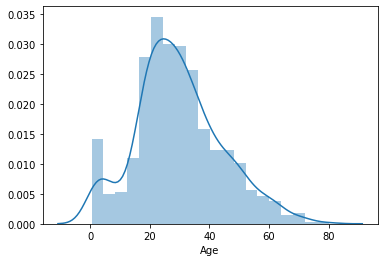

In [16]:
# Se analiza la normalidad para las variables continuas
# Análisis de normalidad para la variable 'Age'
# en el conjunto de datos de entrenamiento
normality_test(df_train, 'Age')

statistic = nan
pvalue = 1.0
La distribución se ajusta a una distribución normal


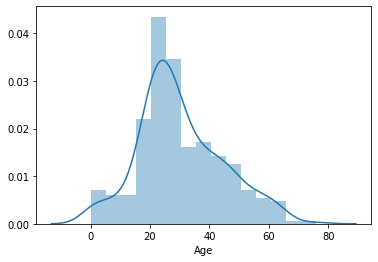

In [17]:
# Análisis de normalidad para la variable 'Age'
# en el conjunto de datos de test
normality_test(df_test, 'Age')

statistic = 0.5218914747238159
pvalue = 1.0789998175301091e-43
La distribución no se ajusta a una distribución normal


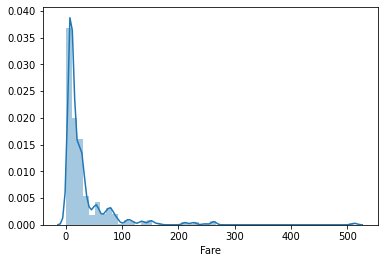

In [18]:
# Análisis de normalidad para la variable 'Fare'
# en el conjunto de datos de entrenamiento
normality_test(df_train, 'Fare')

statistic = nan
pvalue = 1.0
La distribución se ajusta a una distribución normal


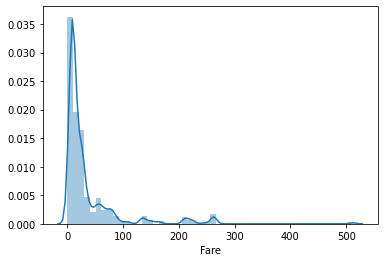

In [19]:
# Análisis de normalidad para la variable 'Fare'
# en el conjunto de datos de test
normality_test(df_test, 'Fare')

statistic = 293.7173156541651
pvalue = 7.702014597162354e-66
variance [Survived = 0] = 200.3749986093805
variance [Survived = 1] = 222.7601688002378
Las varianzas son significativamente difernetes


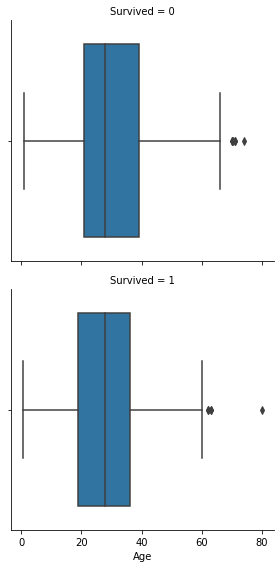

In [20]:
# Análisis de homocedasticidad para la variable 'Age'
homoscedasticity_test(df_train, 'Age')

statistic = 96.2527395111909
pvalue = 1.0111515793725321e-22
variance [Survived = 0] = 983.4249381503206
variance [Survived = 1] = 4422.191853811519
Las varianzas son significativamente difernetes


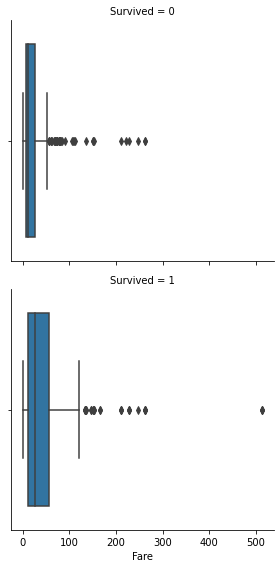

In [21]:
# Análisis de homocedasticidad para la variable 'Fare'
homoscedasticity_test(df_train, 'Fare')

# 3 - Limpieza de datos

## Tratar los valores extremos

In [0]:
# Se define una función para elminar valores extremos
def remove_outliers(X, feature, qmin, qmax):
  X.loc[~X[feature].between(qmin, qmax), feature] = np.nan
  return X

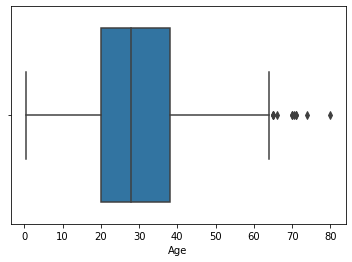

In [23]:
# El análisis de outliers solo tiene sentido para variables continuas
# Se muestra una boxplot de la variable 'Age' para el DataFrame de entrenamiento
plot = sns.boxplot(X_train['Age']);

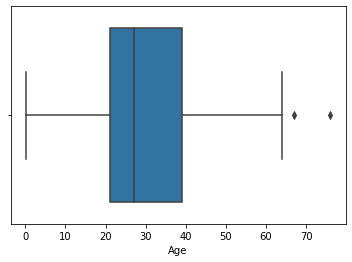

In [24]:
# Se muestra una boxplot de la variable 'Age' para el DataFrame de test
plot = sns.boxplot(X_test['Age']);

In [0]:
# Si se decide eliminar/reducir los outliers
if remove_outilers_quantile > 0:
  # Se eliminan/reduce el número de los valore extremos
  qmin = X_train['Age'].quantile(remove_outilers_quantile)
  qmax = X_train['Age'].quantile(1 - remove_outilers_quantile)
  X_train = remove_outliers(X_train, 'Age', qmin, qmax)
  X_test = remove_outliers(X_test, 'Age', qmin, qmax)

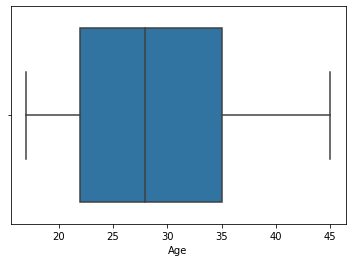

In [26]:
# Si se decide eliminar/reducir los outliers
if remove_outilers_quantile > 0:
  # Se muestra una boxplot de la variable 'Age' 
  # para el DataFrame de entrenamiento
  plot = sns.boxplot(X_train['Age']);

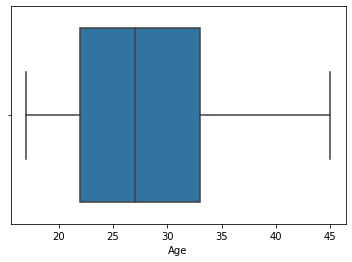

In [27]:
# Si se decide eliminar/reducir los outliers
if remove_outilers_quantile > 0:
  # Se muestra una boxplot de la variable 'SibSp' 
  # para el DataFrame de test
  plot = sns.boxplot(X_test['Age']);

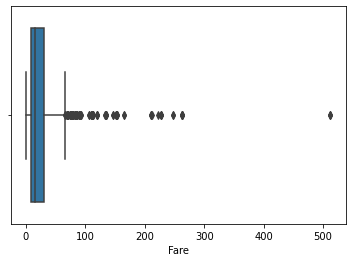

In [28]:
# Se muestra una boxplot de la variable 'SibSp' 
# para el DataFrame de entrenamiento
plot = sns.boxplot(X_train['Fare']);

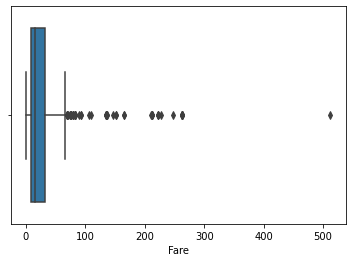

In [29]:
# Se muestra una boxplot de la variable 'SibSp' 
# para el DataFrame de test
plot = sns.boxplot(X_test['Fare']);

In [0]:
# Si se decide eliminar/reducir los outliers
if remove_outilers_quantile > 0:
  qmin = X_train['Fare'].quantile(remove_outilers_quantile)
  qmax = X_train['Fare'].quantile(1 - remove_outilers_quantile)
  X_train = remove_outliers(X_train, 'Fare', qmin, qmax)
  X_test = remove_outliers(X_test, 'Fare', qmin, qmax)

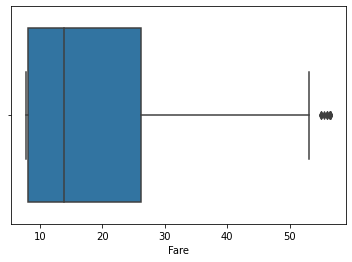

In [31]:
# Si se decide eliminar/reducir los outliers
if remove_outilers_quantile > 0:
  # Se muestra una boxplot de la variable 'Parch' 
  # para el DataFrame de entrenamiento
  plot = sns.boxplot(X_train['Fare']);

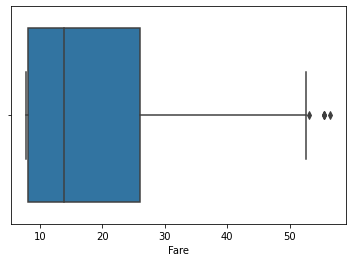

In [32]:
# Si se decide eliminar/reducir los outliers
if remove_outilers_quantile > 0:
  # Se muestra una boxplot de la variable 'Parch' para el DataFrame de test
  plot = sns.boxplot(X_test['Fare']);

In [33]:
# Se muestran las características del DataFrame de entrenamiento
display(X_train.info())
display(X_train.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       511 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      656 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 76.6+ KB


None

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,NaN,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,NaN,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.100,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050,NaN,S


In [34]:
# Se muestran las características del DataFrame de test
display(X_test.info())
display(X_test.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       246 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      299 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


None

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,NaN,1,0,363272,NaN,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,NaN,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Extraer nuevas carcaterísticas

In [0]:
# Se define una función para convertir una variable a categórica
def factorize_feature(X, feature):
  # Se convierte la característica en un variable categórica
  # identificada con un número entero
  X[feature], _list = pd.factorize(X[feature])

  # No interesa imputar los posibles valores perdidos con el valor -1,
  # por lo que se subtituye el valor -1 por NaN
  X_train[feature] = X[feature].replace(-1, np.nan)

  # Se define un diccionario con el identificador de la categoria y su valor
  _dict = {k:int(v) for v, k in enumerate(_list)}
  print(_dict)

  # Se devuelve el diccionario
  return X, _dict

In [36]:
# Para el DataFrame de entrenamiento
# Se genera una nueva característica 'Title' a partir de la extracción 
# de parte de los caractéres de la característica 'Name'
X_train['Title'] = X_train['Name'].str.extract('([A-Za-z]+)\.')

# Se convierte la características 'Title'
# en variables categóricas identificada con un número entero
X_train, title = factorize_feature(X_train, 'Title')

{'Mr': 0, 'Mrs': 1, 'Miss': 2, 'Master': 3, 'Don': 4, 'Rev': 5, 'Dr': 6, 'Mme': 7, 'Ms': 8, 'Major': 9, 'Lady': 10, 'Sir': 11, 'Mlle': 12, 'Col': 13, 'Capt': 14, 'Countess': 15, 'Jonkheer': 16}


In [37]:
# Se muestran las características del DataFrame de entrenamiento
display(X_train.info())
display(X_train.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       511 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      656 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
 10  Title     891 non-null    int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


None

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,NaN,NaN,S,0
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,NaN,C85,C,1
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,NaN,S,2
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.100,C123,S,1
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050,NaN,S,0


In [0]:
# Para el DataFrame de test
# Se genera una nueva característica 'Title' a partir de la extracción 
X_test['Title'] = X_test['Name'].str.extract('([A-Za-z]+)\.')

# Se convierte la característica 'Title' en un variable categórica
# utilizando las categorías de la variable 'Title' del DataFrame de entrenamiento,
# a partir del diccionario generado
X_test['Title'] = X_test['Title'].map(title)

In [39]:
# Se muestran las características del DataFrame de test
display(X_test.info())
display(X_test.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       246 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      299 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
 10  Title     417 non-null    float64
dtypes: float64(3), int64(3), object(5)
memory usage: 39.2+ KB


None

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.0
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,NaN,1,0,363272,NaN,NaN,S,1.0
894,2,"Myles, Mr. Thomas Francis",male,NaN,0,0,240276,9.6875,NaN,Q,0.0
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0.0
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1.0


## Eliminar características

In [40]:
# Se eliminan del DataFrame de entrenamiento las características que no son necesarias
X_train = X_train.drop(columns=['Name', 'Ticket', 'Cabin'])

# Se muestran las características del DataFrame de entrenamiento
display(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       511 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      656 non-null    float64
 6   Embarked  889 non-null    object 
 7   Title     891 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 62.6+ KB


None

In [41]:
# Se eliminan del DataFrame de test las características que no son necesarias
X_test = X_test.drop(columns=['Name', 'Ticket', 'Cabin'])

# Se muestran las características del DataFrame de test
display(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       246 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      299 non-null    float64
 6   Embarked  418 non-null    object 
 7   Title     417 non-null    float64
dtypes: float64(3), int64(3), object(2)
memory usage: 29.4+ KB


None

## Factorizar características

In [42]:
# Para el DataFrame de entrenamiento
# Se convierten las características 'Sex' y 'Embarked' 
# en variables categóricas
X_train, sex = factorize_feature(X_train, 'Sex')
X_train, embarked = factorize_feature(X_train, 'Embarked')

{'male': 0, 'female': 1}
{'S': 0, 'C': 1, 'Q': 2}


In [43]:
# Se muestran las características del DataFrame de entrenamiento
display(X_train.info())
display(X_train.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    int64  
 2   Age       511 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      656 non-null    float64
 6   Embarked  889 non-null    float64
 7   Title     891 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 62.6 KB


None

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
1,3,0,22.0,1,0,NaN,0.0,0
2,1,1,38.0,1,0,NaN,1.0,1
3,3,1,26.0,0,0,7.925,0.0,2
4,1,1,35.0,1,0,53.100,0.0,1
5,3,0,35.0,0,0,8.050,0.0,0


In [0]:
# Para el DataFrame de test
# Se convierten las características 'Sex' y 'Embarked' en un variables categóricas
# utilizando las categorías de las variables 'Sex' y 'Embarked' del DataFrame 
# de entrenamiento, a partir del diccionario generado
X_test['Sex'] = X_test['Sex'].map(sex)
X_test['Embarked'] = X_test['Embarked'].map(embarked)

In [45]:
# Se muestran las características del DataFrame de test
display(X_test.info())
display(X_test.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    int64  
 2   Age       246 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      299 non-null    float64
 6   Embarked  418 non-null    int64  
 7   Title     417 non-null    float64
dtypes: float64(3), int64(5)
memory usage: 29.4 KB


None

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
892,3,0,34.5,0,0,7.8292,2,0.0
893,3,1,NaN,1,0,NaN,0,1.0
894,2,0,NaN,0,0,9.6875,2,0.0
895,3,0,27.0,0,0,8.6625,0,0.0
896,3,1,22.0,1,1,12.2875,0,1.0


## Discretizar características

In [0]:
# Se define una función para convertir en categórica
# una característica a partir de un diccionario con
# el que mapear las categorías
def map_discrete_categories(X, feature, _dict):
  _list = []
  for i, x in enumerate(list(X[feature])):
    found = False
    for k, v in _dict.items():
      try:
        if x in k:
          _list.append(v)
          found = True
          break
      except:
        pass
    if not found:
      _list.append(np.nan)
  X[feature] = _list
  return X

In [47]:
# Si se decide discretizar la variable 'Age'
if age_categories > 0:
  # Se agrupan las muestras en categorías con el mismo número de muestras
  # El número de categorías viene definido por la variable 'age_categories'
  X_train['Age'] = pd.qcut(X_train['Age'], age_categories)

  # Se convierte la característica 'Age' en una variable categórica
  X_train, age = factorize_feature(X_train, 'Age')

{Interval(21.0, 24.0, closed='right'): 0, Interval(36.0, 40.0, closed='right'): 1, Interval(24.0, 26.0, closed='right'): 2, Interval(33.0, 36.0, closed='right'): 3, Interval(26.0, 28.0, closed='right'): 4, Interval(19.0, 21.0, closed='right'): 5, Interval(30.0, 33.0, closed='right'): 6, Interval(16.999, 19.0, closed='right'): 7, Interval(40.0, 45.0, closed='right'): 8, Interval(28.0, 30.0, closed='right'): 9}


In [48]:
# Se muestran las características del DataFrame de entrenamiento
display(X_train.info())
display(X_train.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    int64  
 2   Age       511 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      656 non-null    float64
 6   Embarked  889 non-null    float64
 7   Title     891 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 62.6 KB


None

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
1,3,0,0.0,1,0,NaN,0.0,0
2,1,1,1.0,1,0,NaN,1.0,1
3,3,1,2.0,0,0,7.925,0.0,2
4,1,1,3.0,1,0,53.100,0.0,1
5,3,0,3.0,0,0,8.050,0.0,0


In [0]:
# Si se decide discretizar la variable 'Age'
if age_categories > 0:
  # Se asigna cada valor de la variable 'Age' del 
  # DataFrame de test al identificador numérico de 
  # la categoría que le corresponde, utilizando las categorías
  # de la variable 'Age' del DataFrame de entrenamiento
  map_discrete_categories(X_test, 'Age', age)

In [50]:
# Se muestran las características del DataFrame de test
display(X_test.info())
display(X_test.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    int64  
 2   Age       246 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      299 non-null    float64
 6   Embarked  418 non-null    int64  
 7   Title     417 non-null    float64
dtypes: float64(3), int64(5)
memory usage: 29.4 KB


None

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
892,3,0,3.0,0,0,7.8292,2,0.0
893,3,1,NaN,1,0,NaN,0,1.0
894,2,0,NaN,0,0,9.6875,2,0.0
895,3,0,4.0,0,0,8.6625,0,0.0
896,3,1,0.0,1,1,12.2875,0,1.0


In [51]:
# Si se decide discretizar la variable 'Fare'
if fare_categories > 0:
  # Se agrupa las muestras en categorías con el mismo número de muestras
  # El número de categorías viene definido por la variable 'fare_categories'
  X_train['Fare'] = pd.qcut(X_train['Fare'], fare_categories)

  # Se convierte la características 'Age' en una variable categórica
  X_train, fare = factorize_feature(X_train, 'Fare')

{Interval(7.854, 7.925, closed='right'): 0, Interval(35.5, 56.496, closed='right'): 1, Interval(7.925, 8.662, closed='right'): 2, Interval(18.0, 25.965, closed='right'): 3, Interval(8.662, 11.242, closed='right'): 4, Interval(27.75, 35.5, closed='right'): 5, Interval(13.825, 18.0, closed='right'): 6, Interval(25.965, 27.75, closed='right'): 7, Interval(7.749, 7.854, closed='right'): 8, Interval(11.242, 13.825, closed='right'): 9}


In [52]:
# Se muestran las características del DataFrame de entrenamiento
display(X_train.info())
display(X_train.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    int64  
 2   Age       511 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      656 non-null    float64
 6   Embarked  889 non-null    float64
 7   Title     891 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 62.6 KB


None

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
1,3,0,0.0,1,0,NaN,0.0,0
2,1,1,1.0,1,0,NaN,1.0,1
3,3,1,2.0,0,0,0.0,0.0,2
4,1,1,3.0,1,0,1.0,0.0,1
5,3,0,3.0,0,0,2.0,0.0,0


In [0]:
# Si se decide discretizar la variable 'Fare'
if fare_categories > 0:
  # Se asigna cada valor de la variable 'Fare' del 
  # DataFrame de test al identificador numérico de 
  # la categoría que le corresponde, utilizando las categorías
  # de la variable 'Age' del DataFrame de entrenamiento
  map_discrete_categories(X_test, 'Fare', fare)

In [54]:
# Se muestran las características del DataFrame de test
display(X_test.info())
display(X_test.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    int64  
 2   Age       246 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      299 non-null    float64
 6   Embarked  418 non-null    int64  
 7   Title     417 non-null    float64
dtypes: float64(3), int64(5)
memory usage: 29.4 KB


None

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
892,3,0,3.0,0,0,8.0,2,0.0
893,3,1,NaN,1,0,NaN,0,1.0
894,2,0,NaN,0,0,4.0,2,0.0
895,3,0,4.0,0,0,4.0,0,0.0
896,3,1,0.0,1,1,9.0,0,1.0


## Imputar los valores perdidos

In [0]:
# Se imputan los valores perdidos (o eliminados) utilizndo el método k-Nearest Neighbors
imp = KNNImputer().fit(X_train)
X_train = pd.DataFrame(imp.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns = X_test.columns)

In [56]:
# Se muestran las características del DataFrame de entrenamiento
display(X_train.info())
display(X_train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    float64
 1   Sex       891 non-null    float64
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    float64
 4   Parch     891 non-null    float64
 5   Fare      891 non-null    float64
 6   Embarked  891 non-null    float64
 7   Title     891 non-null    float64
dtypes: float64(8)
memory usage: 55.8 KB


None

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,3.0,0.0,0.0,1.0,0.0,4.4,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,2.6,1.0,1.0
2,3.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0
3,1.0,1.0,3.0,1.0,0.0,1.0,0.0,1.0
4,3.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0


In [57]:
# Se muestran las características del DataFrame de test
display(X_test.info())
display(X_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    float64
 1   Sex       418 non-null    float64
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    float64
 4   Parch     418 non-null    float64
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    float64
 7   Title     418 non-null    float64
dtypes: float64(8)
memory usage: 26.2 KB


None

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,3.0,0.0,3.0,0.0,0.0,8.0,2.0,0.0
1,3.0,1.0,2.4,1.0,0.0,5.6,0.0,1.0
2,2.0,0.0,4.6,0.0,0.0,4.0,2.0,0.0
3,3.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0
4,3.0,1.0,0.0,1.0,1.0,9.0,0.0,1.0


## Reducir la dimensionalidad

Proporción de la variabilidad explicada por elos componentes: 
{0: 0.390701, 1: 0.292593, 2: 0.160694, 3: 0.067522, 4: 0.034344, 5: 0.024856, 6: 0.020086, 7: 0.009203}


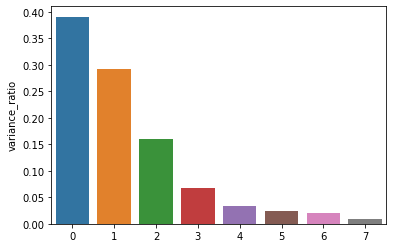

In [58]:
# Se aplica un análisis de componentes principales
# para indentificar las componentes mas información aportan
# en el espacio de características
pca = PCA(n_components = len(X_train.columns)).fit(X_train)
_dict = {k:round(v, 6) for k, v in enumerate(pca.explained_variance_ratio_)}

# Proporción de la variabilidad explicada por las componentes
print('Proporción de la variabilidad explicada por elos componentes: \n' +
      str(_dict))

# Representación gráfica de la proporción de la variabilidad explicada
# por cada una de las componentes
data = pd.DataFrame.from_dict(_dict, orient='index', columns = ['variance_ratio'] )
plot = sns.barplot(x=data.index, y='variance_ratio', data = data)

In [0]:
# Si se decide reducir el número de dimensiones
if dimensions_to_remove > 0:
  # Se aplica el análisis PCA para un número de dimensiones inferior
  # al del espacio de características
  pca = PCA(n_components = len(X_train.columns) - dimensions_to_remove).fit(X_train)
  X_train = pd.DataFrame(pca.transform(X_train))
  X_test = pd.DataFrame(pca.transform(X_test))

In [0]:
# Si se decide reducir el número de dimensiones
if dimensions_to_remove > 0:
  # Se muestran las características del DataFrame de entrenamiento
  display(X_train.info())
  display(X_train.head())

In [0]:
# Si se decide reducir el número de dimensiones
if dimensions_to_remove > 0:
  # Se muestran las características del DataFrame de test
  display(X_test.info())
  display(X_test.head())

## Estandarizar

In [0]:
# Se realiza una estandarización del cojunto de características,
# de manera qu todas las características se ponderen igual en
# los modelos que se implementaran en los siguientes puntos.
# Esto es importante para implementar el modelo
# de red neuronal porque es especialmenete sensible al escalado
scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [63]:
# Se muestran las características del DataFrame de entrenamiento
display(X_train.info())
display(X_train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    float64
 1   Sex       891 non-null    float64
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    float64
 4   Parch     891 non-null    float64
 5   Fare      891 non-null    float64
 6   Embarked  891 non-null    float64
 7   Title     891 non-null    float64
dtypes: float64(8)
memory usage: 55.8 KB


None

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0.827377,-0.737695,-1.787905,0.432793,-0.473674,-0.014208,-0.570766,-0.542822
1,-1.566107,1.355574,-1.373595,0.432793,-0.473674,-0.692374,1.003699,0.037099
2,0.827377,1.355574,-0.959285,-0.474545,-0.473674,-1.671948,-0.570766,0.617020
3,-1.566107,1.355574,-0.544974,0.432793,-0.473674,-1.295189,-0.570766,0.037099
4,0.827377,-0.737695,-0.544974,-0.474545,-0.473674,-0.918430,-0.570766,-0.542822


In [64]:
# Se muestran las características del DataFrame de test
display(X_test.info())
display(X_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    float64
 1   Sex       418 non-null    float64
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    float64
 4   Parch     418 non-null    float64
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    float64
 7   Title     418 non-null    float64
dtypes: float64(8)
memory usage: 26.2 KB


None

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0.827377,-0.737695,-0.544974,-0.474545,-0.473674,1.342125,2.578164,-0.542822
1,0.827377,1.355574,-0.793560,0.432793,-0.473674,0.437903,-0.570766,0.037099
2,-0.369365,-0.737695,0.117923,-0.474545,-0.473674,-0.164911,2.578164,-0.542822
3,0.827377,-0.737695,-0.130664,-0.474545,-0.473674,-0.164911,-0.570766,-0.542822
4,0.827377,1.355574,-1.787905,0.432793,0.767630,1.718884,-0.570766,0.037099


# 4 - Análisis de datos

## Análisis estadístico descriptivo

In [65]:
# Estadísticas del DataFrame de entrenamiento
display(X_train.describe())

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
count,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02
mean,-2.031048e-16,3.162453e-16,1.080318e-16,3.456519e-16,6.716164e-17,2.791133e-17,-6.230208e-17,2.367479e-17
std,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00
min,-1.566107e+00,-7.376951e-01,-1.787905e+00,-4.745452e-01,-4.736736e-01,-1.671948e+00,-5.707655e-01,-5.428218e-01
25%,-3.693648e-01,-7.376951e-01,-6.278361e-01,-4.745452e-01,-4.736736e-01,-9.184295e-01,-5.707655e-01,-5.428218e-01
50%,8.273772e-01,-7.376951e-01,-4.780148e-02,-4.745452e-01,-4.736736e-01,-8.955957e-02,-5.707655e-01,-5.428218e-01
75%,8.273772e-01,1.355574e+00,6.979574e-01,4.327934e-01,-4.736736e-01,8.146622e-01,1.003699e+00,6.170204e-01
max,8.273772e-01,1.355574e+00,1.940889e+00,6.784163e+00,6.974147e+00,1.718884e+00,2.578164e+00,8.735916e+00


In [66]:
# Estadísticas del DataFrame test
display(X_test.describe())

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,-0.051570,0.023493,-0.000027,-0.068631,0.013345,0.027434,0.159967,-0.067231
std,1.007462,1.008165,1.058201,0.813665,1.218251,1.017912,1.079321,0.794717
min,-1.566107,-0.737695,-1.787905,-0.474545,-0.473674,-1.671948,-0.570766,-0.542822
25%,-1.566107,-0.737695,-0.793560,-0.474545,-0.473674,-0.843078,-0.570766,-0.542822
50%,0.827377,-0.737695,0.035061,-0.474545,-0.473674,-0.051884,-0.570766,-0.542822
75%,0.827377,1.355574,0.697957,0.432793,-0.473674,0.965366,1.003699,0.588024
max,0.827377,1.355574,1.940889,6.784163,10.698058,1.718884,2.578164,6.996152


## Análisis de correlación


In [0]:
# Se vuelven a unir las características con la clase a predecir
# para poder aplicar los tests
Xy_train = X_train.copy()
Xy_train['Survived'] = y_train

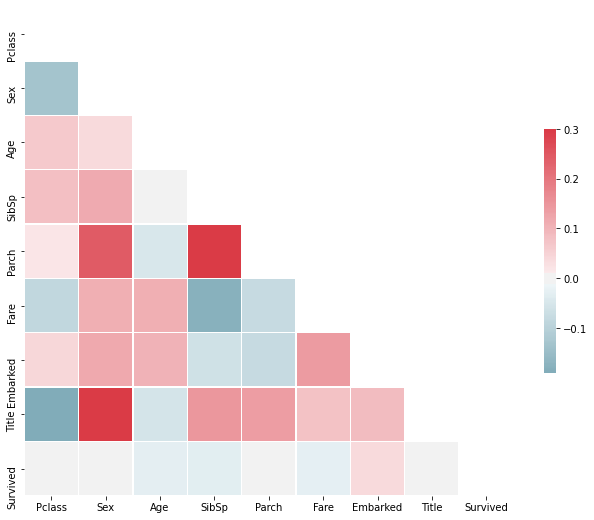

In [68]:
# Se calcula la matriz de correlación
corr = Xy_train.corr()

# Se muestra un gráfico con los valores de la matriz de correlación
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plot = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Análisis predictivo

In [0]:
# Se separa el conjunto de entrenamieto original en un nuevo
# conjunto de entrenamiento y otro de validación del modelo
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size)

### Modeolo de regresion logística

In [97]:
# Se genera un modelo de regresión logística a partir del subconjunto de 
# datos de entrenamiento
model_lr = LogisticRegression(solver = 'lbfgs')
model_lr.fit(X_train, y_train.values.ravel())

# Precisión del modelo de regresión logística
y_pred_lr = model_lr.predict(X_val)

val_acc_lr = round(accuracy_score(y_val, y_pred_lr, normalize=True),6)
val_cmatrix_lr = confusion_matrix(y_val, y_pred_lr)

print('Matriz de confusión del modelo:\n', val_cmatrix_lr)
print('Precisión del modelo:', val_acc_lr)

Matriz de confusión del modelo:
 [[24  3]
 [ 6 15]]
Precisión del modelo: 0.8125


In [98]:
# Generar DataFrame de predicciones a partir del DataFrame de test
df_pred_lr = pd.DataFrame(model_lr.predict(X_test), columns=['Survived'], index = df_test.index)
display(df_pred_lr.head())
display(df_pred_lr.describe())

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


,Survived
count,418.000000
mean,0.358852
std,0.480238
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


### Modelo supervisado: red neuronal

In [0]:
# Se define una función para el entrenamiento de la red neuronal
def train_ann_model(model, X_train, y_train, X_val, y_val, epochs, batch_size, patience, shuffle=True):
    # Se configura el entrenamiento para finalizarlo antes de tiempo si el error de validación
    # crece durante el número de épocas establecido por el parámetro patience
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

    # Se guarda el modelo con menor error de validación
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

    # Se entrena el modelo
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=shuffle, callbacks=[es, mc])

    # Se muestra una gráfica con la evolución de los errores de entrenamiento
    # y validación durante el entrenamieto
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.show()
  
    # Se carga el modelo con menor error de validación
    model = load_model('best_model.h5')

    # Se evalua la precisión del modelo obtenido
    trainScore = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
    valScore = model.evaluate(X_val, y_val, batch_size=batch_size, verbose=0)
  
    print('Train Loss: %.6f' % trainScore[0])
    print('Train Accuracy: %.6f' % trainScore[1])
    print('Val Loss: %.6f' % valScore[0])
    print('Val Accuracy: %.6f' % valScore[1])
  
    # Se devuelve el modelo obtenido después del entrenamieto
    return model

In [0]:
# Se define una función para entrenar red neuronal
def ann_model(X_train, X_val, y_train, y_val, epochs, batch_size, lr, patience, 
              neurons, shuffle=True): 
  # Se obtienen el número de neuronas de entrada y salida del la red neuronal
  # a partir de las dimensiones del conjunto de entrenamiento
  n_input =  X_train.shape[1]
  n_output = y_train.shape[1]
  
  # Se define la red neuronal
  model = Sequential([
      # Capa de entrada con el numero de neuronas obtenido anteriormente
      # y función de activación relu
      Dense(n_input, input_dim=n_input, activation='relu'),
      # Capa oculta con el número de neuronas definido como parámetro
      # y función de activación relu
      Dense(neurons, activation='relu'),
      # Capa de salida con el número de neuronas obtenido anteriormente 
      # y función de activación sigmoide para que la red funcione como 
      # un clasificador binario
      Dense(n_output, activation='sigmoid')
  ])
  
  # Se optimiza la red neuronal definida 
  # con la función de coste binary_crossentropy
  # utilizando como ratio de aprendizaje el definido como parámetro
  model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', 
                metrics=['accuracy'])

  # Se entrena el modelo de red neuronal definido
  model = train_ann_model(model, X_train, y_train, X_val, y_val, epochs, 
                          batch_size, patience, shuffle)
  
  # Se devuelve el modelo obtenido después del entrenamieto
  return model

In [0]:
# Predicciones para el modelo de red neuronal
def predict_with_ann_model(model, X, batch_size):
  # Se realizan las preducciones para el modelo dado
  y_pred = (model.predict(X, batch_size=batch_size) > 0.5).astype("int32")

  # Se devuelven las predicciones
  return y_pred

Epoch 1/200
423/423 [==============================] - 1s 2ms/step - loss: 0.7217 - accuracy: 0.3570 - val_loss: 0.7046 - val_accuracy: 0.5208
Epoch 2/200
423/423 [==============================] - 1s 1ms/step - loss: 0.6541 - accuracy: 0.6099 - val_loss: 0.6562 - val_accuracy: 0.5625
Epoch 3/200
423/423 [==============================] - 1s 1ms/step - loss: 0.6122 - accuracy: 0.6312 - val_loss: 0.6237 - val_accuracy: 0.5625
Epoch 4/200
423/423 [==============================] - 1s 1ms/step - loss: 0.5824 - accuracy: 0.6383 - val_loss: 0.5989 - val_accuracy: 0.6250
Epoch 5/200
423/423 [==============================] - 1s 1ms/step - loss: 0.5589 - accuracy: 0.7281 - val_loss: 0.5777 - val_accuracy: 0.7083
Epoch 6/200
423/423 [==============================] - 1s 1ms/step - loss: 0.5389 - accuracy: 0.7612 - val_loss: 0.5580 - val_accuracy: 0.7708
Epoch 7/200
423/423 [==============================] - 1s 1ms/step - loss: 0.5206 - accuracy: 0.7707 - val_loss: 0.5404 - val_accuracy: 0.7708

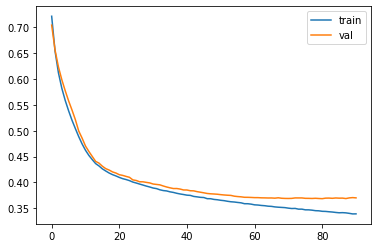

Train Loss: 0.340295
Train Accuracy: 0.851064
Val Loss: 0.368575
Val Accuracy: 0.833333


In [94]:
# Se implementa y entrena el modelo de red neuronal
model_ann = ann_model(X_train, X_val, y_train, y_val, epochs=epochs, batch_size=batch_size, lr=lr, patience=patience, neurons=neurons)

In [99]:
# Precisión del modelo de red neuronal
y_pred_ann = predict_with_ann_model(model_ann, X_val, batch_size=batch_size)

val_acc_ann = round(accuracy_score(y_val, y_pred_ann, normalize=True),6)
val_cmatrix_ann = confusion_matrix(y_val, y_pred_ann)

print('Matriz de confusión del modelo:\n', val_cmatrix_ann)
print('Precisión del modelo:', val_acc_ann)

Matriz de confusión del modelo:
 [[23  4]
 [ 4 17]]
Precisión del modelo: 0.833333


In [100]:
# Generar DataFrame de predicciones a partir del DataFrame de test
df_pred_ann = pd.DataFrame(predict_with_ann_model(model_ann, X_test, batch_size=batch_size), columns=['Survived'], index = df_test.index)
display(df_pred_ann.head())
display(df_pred_ann.describe())

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


,Survived
count,418.000000
mean,0.354067
std,0.478803
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


# 5 - Subir predicciones a Kaggle

In [101]:
# Guardar las predicciones realizadas a partir del DataFrame de test
# como csv y subirlas a Kaggle
# Si se ha decidido subir los resultados del modelo de regresión logística
if lr_pred_to_kaggle:
  df_pred_lr.to_csv('submission.csv', index=True)  
  !kaggle competitions submit -c titanic -f submission.csv -m "New lr_model test prediction"

100% 2.77k/2.77k [00:05<00:00, 559B/s]
Successfully submitted to Titanic: Machine Learning from Disaster

In [102]:
# Si se ha decidido subir los resultados del modelo de red neuronal
if ann_pred_to_kaggle:
  df_pred_ann.to_csv('submission.csv', index=True)  
  !kaggle competitions submit -c titanic -f submission.csv -m "New ann_model test prediction"

100% 2.77k/2.77k [00:03<00:00, 773B/s]
Successfully submitted to Titanic: Machine Learning from Disaster